In [1]:
from foamdapy.tools import *
from foamdapy import EnSim
from foamdapy.foamer import OFCase
import matplotlib.pyplot as plt
from foamdapy.ensemble_builder import ensemble_case_builder
import numpy as np

# customMixerVesselでデータ同化を行う
## 問題設定
customMixerVesselにて、1.51[s]以降の時間発展を予測する。
アンサンブルメンバはt= 1.5, 1.5005, ..., 1.5095 の20メンバ。
真値=観測値とする

## 解法
* 0.001sの予報⇔解析を繰り返す。
* 状態変数 $x=(u, p, alpha.oil, ocr)$とする。　※$ocr=$ patchAverage(outlet, alpha.oil)
* 観測変数 $y=(u_{obs}, p_{obs}, alpha.oil_{obs}, ocr_{obs})$ ←obsは観測空間のランダムx%


## 計算フロー
1. アンサンブルメンバの用意。
2. Forcast $t_i$ + 0.001秒まで計算
3. Analysis 全アンサンブルメンバの $t_i$ + 0.001 に解析結果を書き込む
4. $t_i$ + 0.001 ⇒　$t_i$とし、2に戻る。



## ディレクトリ構造
foamdapy  
└── **notebooks**  
    　　　　├── **ensim0**   
    　　　　│　　├── **customMixerVessel**    
    　　　　│　　├── **customMixerVessel.true**    
    　　　　│　　├── **member**  
    　　　　│　　│　　├── **customMixerVessel_00**  
    　　　　│　　│　　├── **customMixerVessel_01**  
    　　　　│　　│　　...  
    　　　　│　　│　　└── **customMixerVessel_19**   
    　　　　│　　└── **log**  
    　　　　│　　 　　├── time_xf.npy  
    　　　　│　　 　　├── time_y0.npy  
    　　　　│　　 　　├── time_xa.npy  
    　　　　│　　 　　└── time_xa1.npy  
    　　　　└── tut_customMixervessel.ipynb　　

## 1.True Case 及びアンサンブルメンバの準備

In [2]:
%%bash
endir="./ensim0"
pwd_dir=`pwd`

# ディレクトリあるなら実行しない
if [ -d $endir ]; then exit; fi;
# OpenFOAMの環境変数を読み込んでいないなら実行しない
if [ ! -d $FOAM_TUTORIALS ]; then  exit; fi;

# ディレクトリ生成
mkdir -p $endir

# no_DA caseのコピー
cp -r ../of_cases/customMixerVessel* $endir


# True Caseを安定状態まで計算(1.5s)
cd $endir/customMixerVessel.true
./Allrun > log.Allrun 2>&1

# True Case 答え合わせのための計算(1.55sまで)
# controlDictの改変
sed 's/endTime         1.5;/endTime         1.55;/' -i system/controlDict
sed 's/writeInterval   1.5;/writeInterval   0.0005;/' -i system/controlDict
multiphaseEulerFoam > log.multiphaseEulerFoam_1.55 2>&1

cd $pwd_dir


# No DA Caseを安定状態まで計算(1.5s)
cd $endir/customMixerVessel
./Allrun > log.Allrun 2>&1

# アンサンブルメンバ化のための計算(1.51s)
# controlDictの改変
sed 's/endTime         1.5;/endTime         1.51;/' -i system/controlDict
sed 's/writeInterval   1.5;/writeInterval   0.0005;/' -i system/controlDict
multiphaseEulerFoam > log.multiphaseEulerFoam_1.51 2>&1

cd $pwd_dir

In [3]:
endir="./ensim0"
casesbuilder = ensemble_case_builder(f"{endir}/customMixerVessel",f"{endir}/member", "customMixerVessel_")
casesbuilder.create_member(1.5, 1.5095, 0.0005, 1.51)

!ls ensim0/member


customMixerVessel_00  customMixerVessel_07  customMixerVessel_14
customMixerVessel_01  customMixerVessel_08  customMixerVessel_15
customMixerVessel_02  customMixerVessel_09  customMixerVessel_16
customMixerVessel_03  customMixerVessel_10  customMixerVessel_17
customMixerVessel_04  customMixerVessel_11  customMixerVessel_18
customMixerVessel_05  customMixerVessel_12  customMixerVessel_19
customMixerVessel_06  customMixerVessel_13


In [4]:
import random
from foamdapy import EnSim
random.seed(0)

n_cells = 3312
x_names = ["U.air", "U.oil","alpha.air","alpha.oil", "p_rgh"]
n_x_scaler = 9
y_names = ["U.air", "U.oil","alpha.air","alpha.oil", "p_rgh"]
n_y_scaler = 9 #ベクトル問題解決までは = n_xscaler
n_ensemble = 20

n_obs_cells = n_cells//2
obs_cells = random.sample(range(n_cells), n_obs_cells)
obs_cells.sort()

ensim = EnSim(f"{endir}/member/", "customMixerVessel_", x_names, n_x_scaler, n_cells, n_ensemble, y_names,n_y_scaler, obs_cells, f"{endir}/customMixerVessel.true",4)

# 2. データ同化
## 初期(t=1.51)残差

In [5]:
true_case = OFCase(f"{endir}/customMixerVessel.true")
tname ="1.51"

ensim.num_cpus=4
ensim.start_ray()
ensim.set_xf("1.51")
ensim.shutdown_ray()

xt = true_case.getValues(tname, ensim.x_names)
dx = ensim.xf - xt

rmse_i = np.zeros(ensim.n_x_scaler)
for i in  range(ensim.n_x_scaler):
    dxi = dx[:,i*ensim.n_cells:(i+1)*ensim.n_cells]
    sqdxi = dxi * dxi
    rmse = np.sqrt(sqdxi.mean())
    rmse_i[i] = rmse

rmse_all = np.vstack([rmse_i])



2024-06-30 22:09:25,114	INFO worker.py:1752 -- Started a local Ray instance.


## 予報ー解析の時間発展

In [ ]:
!mkdir ensim0/log
np.random.seed(0)

ensim.set_R_diag()

ensim.start_ray()

for t in np.arange(1.511,1.55,0.001):
    tname = decimal_normalize(t)
    print(f"now t={tname} [s]")
    
    ensim.ensemble_forcast(tname)
    np.save(f"{endir}/log/{tname}_xf.npy", ensim.xf)

    ensim.observation(tname)
    y_noise = np.array([np.random.normal(0,np.sqrt(sc)) for sc in ensim.R_diag])
    ensim.y0 += y_noise

    np.save(f"{endir}/log/{tname}_y0.npy", ensim.y0)

    ensim.letkf_update()
    np.save(f"{endir}/log/{tname}_xa.npy", ensim.xa)

    #inflation
    #RTPS
    xa_mean = ensim.xa.mean(axis=0)
    dxa = ensim.xa - xa_mean
    sigma_xa = ensim.xa.std(axis=0)
    sigma_xf = ensim.xf.std(axis=0)
    beta = 0.7
    with np.errstate(all='ignore'):
        rmd =(beta*sigma_xf +(1-beta)*sigma_xa)/sigma_xa
    rmd = np.nan_to_num(rmd)

    ensim.xa = xa_mean + rmd * dxa
    
    #bounds
    st = ensim.n_cells*6 #from alpha.air
    ed = -ensim.n_cells# to alpha.oil
    ensim.limit_val_in_xa(st, ed, 0.0, 1.0)
    st = ensim.n_cells*2 #from Uz.air
    ed = -ensim.n_cells*6# to Uz.air
    ensim.limit_val_in_xa(st, ed, 0.0, 0.0)
    st = ensim.n_cells*5 #from Uz.oil
    ed = -ensim.n_cells*3# to Uz.oil
    ensim.limit_val_in_xa(st, ed, 0.0, 0.0)
    np.save(f"{endir}/log/{tname}_xa1.npy", ensim.xa)

    # rmse record
    xt = true_case.getValues(tname, ensim.x_names)
    dx = ensim.xa - xt
    rmse_i = np.zeros(ensim.n_x_scaler) 
    for i in range(ensim.n_x_scaler):
        dxi = dx[:,i*ensim.n_cells:(i+1)*ensim.n_cells]
        sqdxi = dxi * dxi
        rmse = np.sqrt(sqdxi.mean())
        rmse_i[i] = rmse
    rmse_all = np.vstack([rmse_all,rmse_i])

    bktname = decimal_normalize(t- 0.00001)
    ensim.bkup_time_dir(tname, bktname)
    ensim.update_cases(tname)

np.save(f"{endir}/log/rmse_all.npy", rmse_all)
ensim.shutdown_ray()

## 残差plot

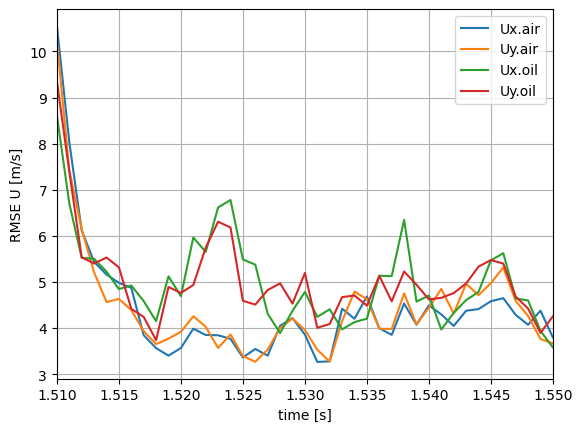

In [8]:
import matplotlib.pyplot as plt

i=[0,1,3,4]
leg = ["Ux.air","Uy.air","Ux.oil","Uy.oil"]
ylab = "RMSE U [m/s]"

rmse = rmse_all[:,i]
t = np.arange(1.51,1.55, 0.001)

fig=plt.figure()
plt.plot(t,rmse)
plt.xlabel("time [s]")
plt.xlim([1.51,1.55])
plt.legend(leg)
plt.ylabel(ylab)
plt.grid(True)
plt.savefig("rmse_u.png")
plt.savefig("rmse_u.svg")

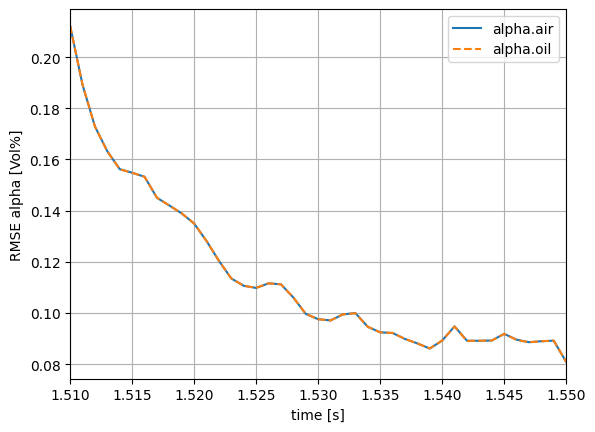

In [9]:
i=[6,7]
leg = ["alpha.air","alpha.oil"]
ylab = "RMSE alpha [Vol%]"

rmse = rmse_all[:,i]
t = np.arange(1.51,1.55, 0.001)

fig=plt.figure()
plt.plot(t,rmse[:,0])
plt.plot(t,rmse[:,1], linestyle='dashed')
plt.xlabel("time [s]")
plt.xlim([1.51,1.55])
plt.legend(leg)
plt.ylabel(ylab)
plt.grid(True)
plt.savefig("rmse_alpha.png")
plt.savefig("rmse_alpha.svg")

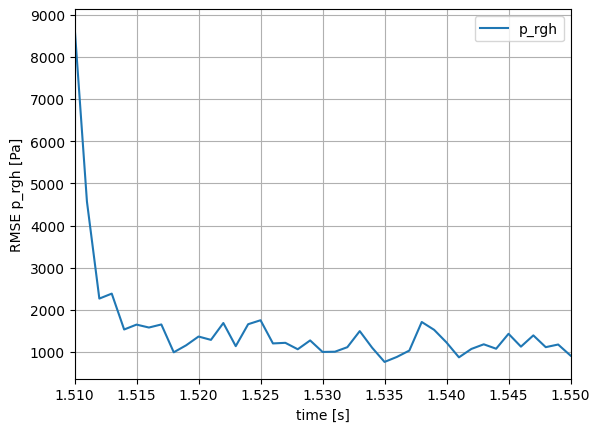

In [10]:
i=[8]
leg = ["p_rgh"]
ylab = "RMSE p_rgh [Pa]"

rmse = rmse_all[:,i]
t = np.arange(1.51,1.55, 0.001)

fig=plt.figure()
plt.plot(t,rmse)
plt.xlabel("time [s]")
plt.xlim([1.51,1.55])
plt.legend(leg)
plt.ylabel(ylab)
plt.grid(True)

plt.savefig("rmse_p.png")
plt.savefig("rmse_p.svg")